## Práctica de Clasificación Lineal: Regresión Logística

Daniel Garcia Diaz (garciad@ifca.unican.es)

En esta práctica utilizaremos el dataset MNIST, compuesto por 60000 imágenes de train y 10000 imagenes de test (de 28x28 pixeles) correspondientes a distintas versiones digitalizadas de los dígitos 0, ..., 9. 

Descargamos el dataset que vamos a utilizar.

In [1]:
# Set the directory to be able to read the data properly
# rm(list=ls())
#setwd("")

In [2]:
#Install the necessary packages
install.packages("R.utils")

Warning message in install.packages("R.utils"):
“installation of package ‘R.utils’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [6]:
# download data from http://yann.lecun.com/exdb/mnist/
download.file("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
              "train-images-idx3-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
              "train-labels-idx1-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
              "t10k-images-idx3-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
              "t10k-labels-idx1-ubyte.gz")

In [10]:
# gunzip the files
R.utils::gunzip("train-images-idx3-ubyte.gz")
R.utils::gunzip("train-labels-idx1-ubyte.gz")
R.utils::gunzip("t10k-images-idx3-ubyte.gz")
R.utils::gunzip("t10k-labels-idx1-ubyte.gz")

ERROR: Error in loadNamespace(name): there is no package called ‘R.utils’


4 archivos diferentes para crear los datasets de train (x_train->train-image e y_train->train-labels) y de test (x->t10k-images e y->t10k-labels).

Funciones para cargar los archivos


In [3]:
# load image files
load_image_file = function(filename) {
  ret = list()
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n    = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  nrow = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  ncol = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  x = readBin(f, 'integer', n = n * nrow * ncol, size = 1, signed = FALSE)
  close(f)
  data.frame(matrix(x, ncol = nrow * ncol, byrow = TRUE))
}

# load label files
load_label_file = function(filename) {
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  y = readBin(f, 'integer', n = n, size = 1, signed = FALSE)
  close(f)
  y
}

In [4]:
# load images
x_train = load_image_file("train-images-idx3-ubyte")
x_test  = load_image_file("t10k-images-idx3-ubyte")

# load labels
y_train = load_label_file("train-labels-idx1-ubyte")
y_test  = load_label_file("t10k-labels-idx1-ubyte")

Dibujamos los 6 primeros digitos para ver el dataset que tenemos

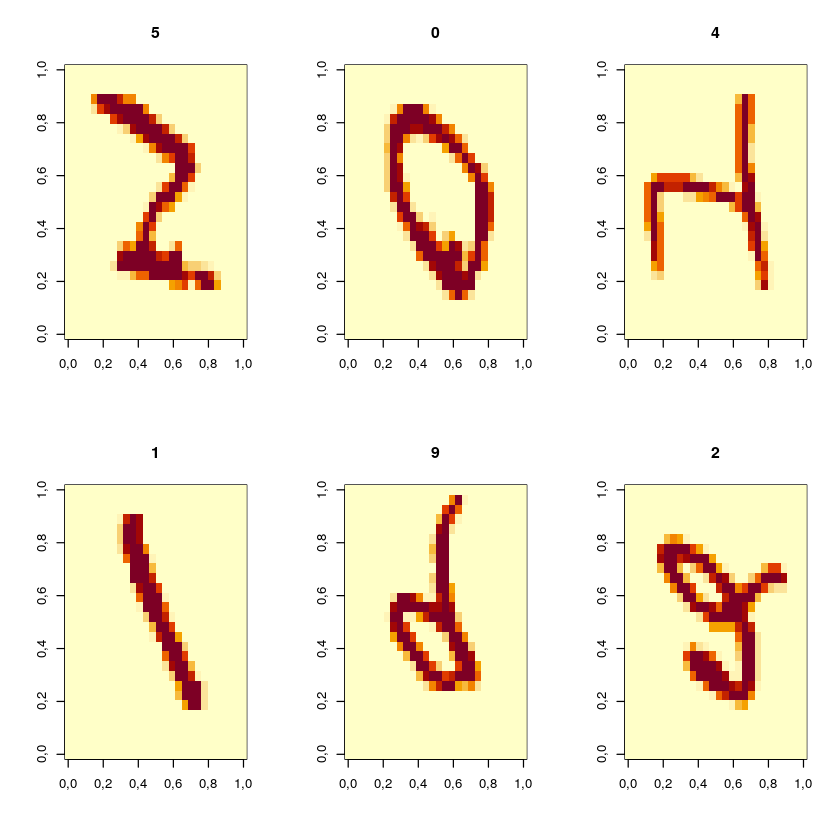

In [5]:
# Dibujamos los 6 primeros dígitos de la base de datos
par(mfrow = c(2,3))
for (i in 1:6) {
    image(matrix(as.matrix(x_train[i,1:784]), nrow = 28, ncol = 28))
    title(y_train[i])
}

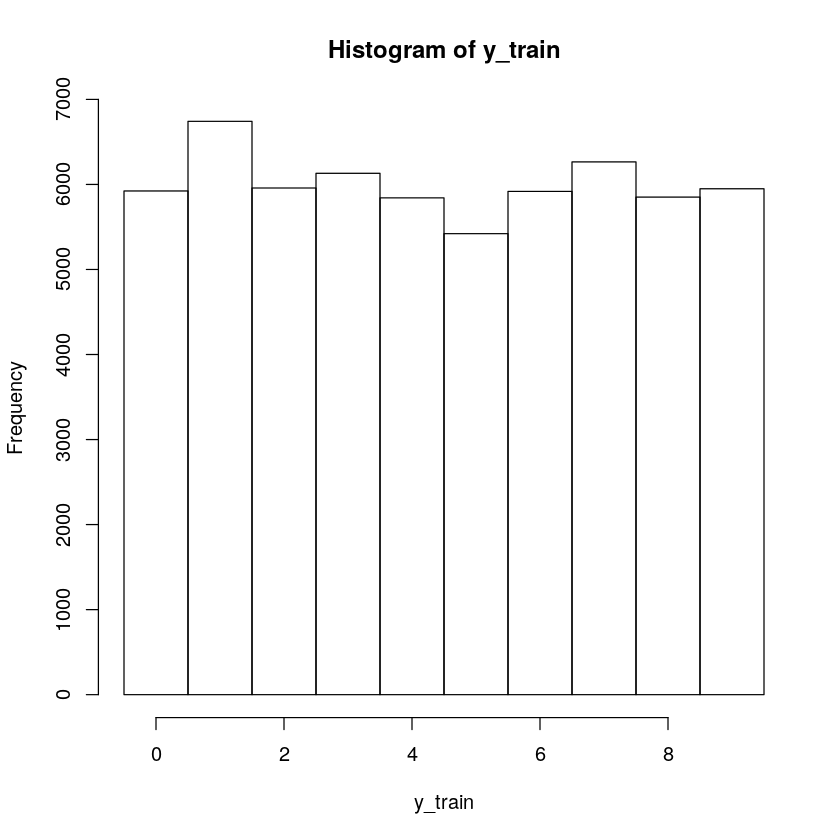

In [6]:
# Cada dígito está igualmente representado en la muestra
hist(y_train, breaks = -0.5:9.5)

El objetivo es clasificar correctamente cada una de las imágenes, utilizando el valor de los 784 pixeles. Este problema se encuandra dentro de la clasificación multi-categoría (tenemos 10 posibles clases a predicir para cada dato). 

Para simplificar estos problemas, se suelen consideran tantos problemas binarios (predecir sí o no) independientes como categorías se tengan. Es decir, un modelo para clasificar 0 (si o no), otro para 1, etc. En este ejemplo, consideramos el dígito '9' y el objetivo es predecir si una imagen es 9 o no.

In [7]:
# Seleccionamos un dígito concreto para tratar de predecirlo. Por ejemplo el nueve
# y9 = 1 si el dígito es 9 y 0 en caso contrario
y9 <- y_train;
y9[which(y_train != 9)] <- 0 ; y9[which(y_train == 9)] <- 1

In [8]:
# Construimos un dataframe para entrenar el modelo
dat <- data.frame(y9,x_train)

Como el tamaño de la muestra es muy grande (60000 imagenes), seleccionamos una muestra para entrenar; por ejemplo, los 5000 primeros dígitos.

In [9]:
i<- 1:5000;
j<-5001:10000
#Random sampling
#i<-sample(1:dim(x)[1],5000);
datT <- dat[i,]
datt <- dat[j,]

Aunque no es el modelo adecuado, ya que no está acotada y puede tomar valores mucho mayores que 1 o menores que 0, construimos primero un modelo de regresión lineal para estos datos.

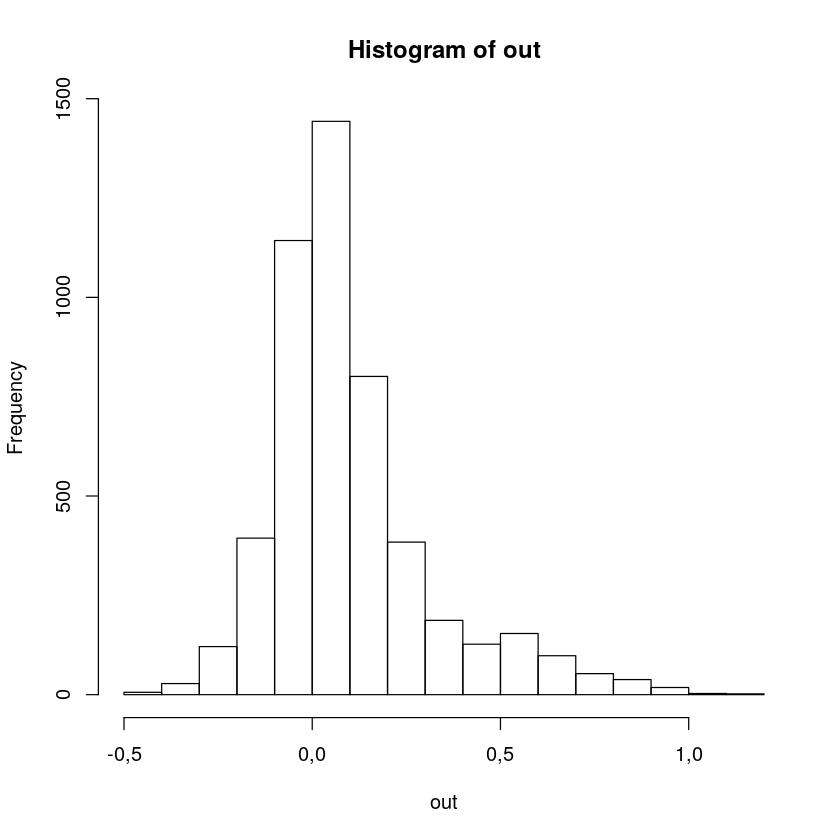

In [10]:
# Entrenamos primero un modelo lineal
model <- lm(datT$y9~., data = datT)
out <- model$fitted.values
# El histograma muestra valores predichos (incluyendo negativos y mayores que 1)
hist(out)

Hacemos la salida del modelo binaria considerando el umbral en 0.5 (a modo de probabilidad) y calculamos la tasa de acierto con los datos de train

In [11]:
# Hacemos binaria la salida considerando el umbral 0.5 (a modo de probabilidad)
outbin <- as.double(out > 0.5)

# Tasa de acierto (en entrenamiento)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)

[1] 96,18

In [12]:
# Tasa de acierto de test
out1<- predict(object=model, newdata = datt);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message in predict.lm(object = model, newdata = datt):
“prediction from a rank-deficient fit may be misleading”


[1] 94,68

Ahora construimos un modelo de regresión logística utilizando la función 'glm' con la familia 'family = binomial(link = "logit")'

In [13]:
model1 <- glm(datT$y9~., data = datT, family = binomial(link = "logit"))


# Problemas de convergencia con tantas variables
# Coefficients: (138 not defined because of singularities)
# Tasa de acierto (Train)
out2 <- model1$fitted.values
outbin2 <- as.double(out2 > 0.5)
100*sum(diag(table(datT[,1], outbin2))) / length(outbin2)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 98,26

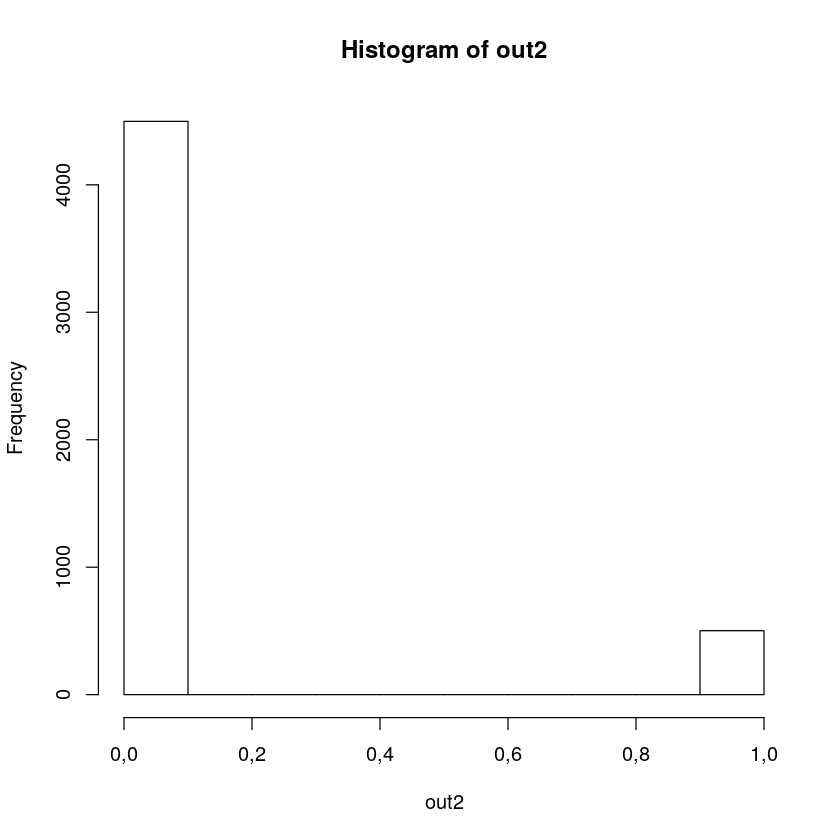

In [14]:
hist(out2)

In [15]:
# Tasa de acierto (test)
out3<- predict(object=model1, newdata = datt);
outbin3 <- as.double(out3 > 0.5)
100*sum(diag(table(datt[,1], outbin3))) / length(outbin3)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 92,18

Las inestabilidades numéricas se producen por la alta dimensionalidad de los datos. Algunos de los coeficientes resultan redundantes y el proceso de optimización no converge.
### (195 not defined because of singularities).

Una solución a este problema es reducir la dimensionalidad del conjunto de predictores. Para ello existen técnicas eficientes (como los métodos de regularización o las Componentes Principales) que se verán más adelante. En esta práctica utilizamos un entresacado de información, considerando sólo uno de cada 20 pixeles.

In [16]:
#Modelo de regresión lineal
j<-seq(1,784,20)
model <- lm(datT$y9~., data = datT[,j])
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

[1] 90,28

Warning message in predict.lm(object = model, newdata = datt[, j]):
“prediction from a rank-deficient fit may be misleading”


[1] 91,1

In [17]:
#Regresión logística
j<-seq(1,784,20)
model <- glm(datT$y9~., data = datT[,j], family = binomial(link = "logit"))
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 92,02

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 92,26

# PRACTICA 1

Construir un modelo de clasificación para cada dígito, y obtener una ranking de los dígitos en base a su capacidad predictiva (el primero el que mejor se predice, etc.). Para evaluar la capacidad predictiva considerando el error de test obtenido al separar aleatoriamente la muestra en un conjunto de train (n=10000) y el resto de test. 

Nota: usar la función 'sample'. 

Nota2: Elige un entresacado óptimo para que la capacidad predictiva no se reduzca y se reduzca la dimensión el máximo posible.

## Empiezo por 0

In [18]:
# Train: 7500 imagenes escogidas aleatoriamente 
# (me dan la misma accuracy que 10000, 
# pero el entrenamiento tarda menos)
# Test: todas las demas    
i <- sample(1:60000, 7500)

# el numero que quiero estudiar
N = 0

# y_train: sample de train

# añado una columna a la muestra de train, que vale:
# 1 si es el numero que queremo
# 0 si es otro numero

my.y <- y_train;
my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

my.dat <- data.frame(my.y,x_train)

my.dat.train <- my.dat[i,]
my.dat.test  <- my.dat[-i,]

# entreno el modelo logistico con 5000 imagenes (considero todos los pixeles de la imagen)

my.model <- glm(my.dat.train$my.y~., data = my.dat.train, family = binomial(link = "logit"))

# Tasa de acierto (Train)
out.train <- my.model$fitted.values
out.bin <- as.double(out.train > 0.5)
100*sum(diag(table(my.dat.train[,1], out.bin))) / length(out.bin)

# Matriz de confusion (Train)
table(my.dat.train[,1], out.bin)

# Tasa de acierto (test)
out.test<- predict(object=my.model, newdata = my.dat.test);
out.bin.test <- as.double(out.test > 0.5)
100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test)

# Matriz de confusion (test)
table(my.dat.test[,1], out.bin.test)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 100

   out.bin
       0    1
  0 6774    0
  1    0  726

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 96,89333

   out.bin.test
        0     1
  0 46050  1253
  1   378  4819

### Sampleando los pixeles y estudiando todos los digitos

In [20]:
# Train: 5000 imagenes escogidas aleatoriamente
# Test: todas las demas
i <- sample(1:60000, 5000)

my.results.vector <-c()

numbers <- seq(0,9)

# el numero que quiero estudiar
for (N in numbers){
    #print(N)

    # y_train: sample de train

    # añado una columna a la muestra de train, que vale:
    # 1 si es el numero que queremo
    # 0 si es otro numero

    my.y <- y_train;
    my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

    my.dat <- data.frame(my.y,x_train)

    my.dat.train <- my.dat[i,]
    my.dat.test  <- my.dat[-i,]

    # Sample aleatorio de los pixeles que considero
    #j <- sample(0:784, 39)
    j <- seq(1,784,20)

    # Entrenamiento del modelo
    my.model <- glm(my.dat.train$my.y~., data = my.dat.train[,j], family = binomial(link = "logit"))

    # Tasa de acierto (test)
    out.test<- predict(object=my.model, newdata = my.dat.test);
    out.bin.test <- as.double(out.test > 0.5)

    # Guardo la accuracy
    my.results.vector <- c(my.results.vector, 100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test))
}

names(my.results.vector) <-  numbers
sort.int(my.results.vector, index.return = T, decreasing = T)$x

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, n

0        1        7        2        6        4        5        3 
96,34182 96,05273 94,57273 94,51818 93,53818 93,19455 92,40727 92,22909 
       8        9 
92,22364 91,59455

## PRACTICA 2

Tener en cuenta la variabilidad del error de test a la hora de construir el ranking anterior. Para ello, además de calcular la tasa de acierto para cada dígito, considerar también un "intervalo de confianza" obtenido como la dispersión (desviación típica) de 10 medidas de test obtenidas con 10 muestras aleatorias distintas. ¿Existe algún dígito que pueda predecirse significativamente mejor que los demás?

In [21]:
# Train: 5000 imagenes escogidas aleatoriamente
# entre las primeras 10000
# dejo así las otras 50000 para las 10 muestras de test

# Test: todas las demas
i <- sample(1:10000, 5000)

my.results.vector <- c()
my.results.matrix <- matrix(, nrow = 1, ncol = 0)

numbers <- seq(0,9)

# el numero que quiero estudiar
for (N in numbers){
    #print(N)

    # y_train: sample de train

    # añado una columna a la muestra de train, que vale:
    # 1 si es el numero que queremo
    # 0 si es otro numero

    my.y <- y_train;
    my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

    my.dat <- data.frame(my.y,x_train)

    my.dat.train <- my.dat[i,]

    # Considero 1 de cada 20 pixeles
    j <- seq(1,784,20)

    # Entrenamiento del modelo
    my.model <- glm(my.dat.train$my.y~., data = my.dat.train[,j], family = binomial(link = "logit"))

    # test (repetido 10 veces)
    for (z in 1:10){
    
        # Test: 5000 imagenes aleatorias
        q <- sample(10001:60000, 5000)
        my.dat.test  <- my.dat[q,]

        # Tasa de acierto (test)
        out.test<- predict(object=my.model, newdata = my.dat.test);
        out.bin.test <- as.double(out.test > 0.5)

        #print(100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test))
        
        # Guardo la accuracy
        my.results.vector <- c(my.results.vector, 100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test))
    }
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scal

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scal

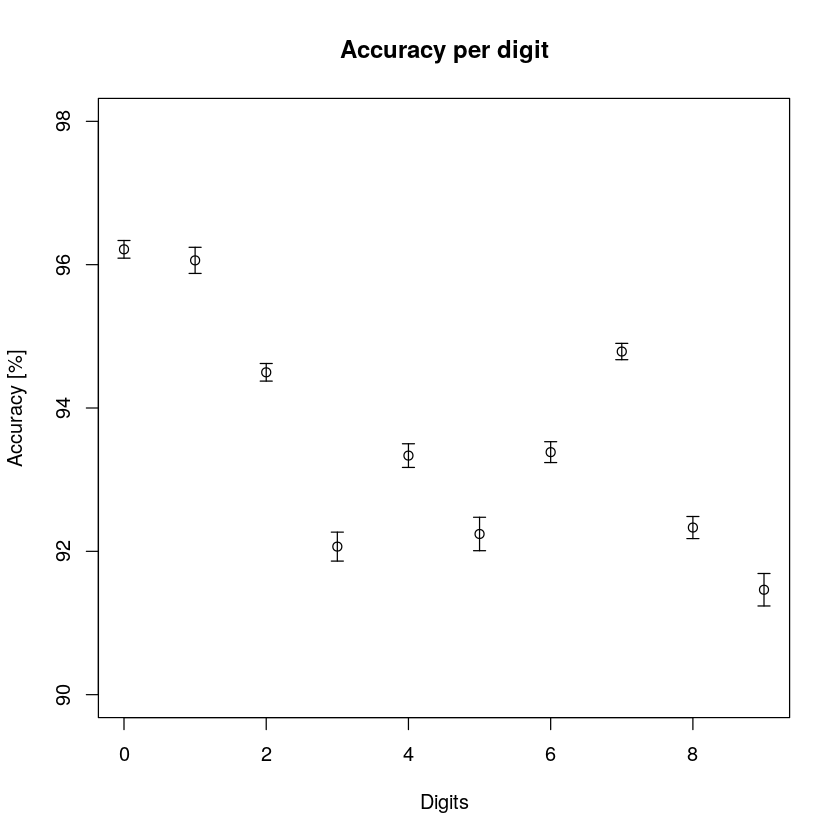

In [22]:
my.results.matrix <- matrix(my.results.vector, nrow = 10, ncol = 10)

my.mean.values <- apply(my.results.matrix, FUN = mean, MARGIN = 2)

my.sd <- apply(my.results.matrix, FUN = sd, MARGIN = 2)

plot(numbers, my.mean.values,
    ylim = c(90,98),
    xlab = "Digits",
    ylab = "Accuracy [%]",
    main = "Accuracy per digit"
    )

arrows(numbers, my.mean.values - my.sd / 2, numbers, my.mean.values + my.sd / 2, length = 0.05, angle = 90, code = 3)

Se observa que hay números, como el '0' y el '1', que se clasifican mejor que otros ('3', '5', '8', '9').

Eso depende probablemente del hecho que estos últimos son más parecidos entre si, haciendo que sea más complicado distinguirlos.

## TRABAJO EXTRA 

Hasta ahora hemos utilizado la tasa de acierto como medida de validación de los clasificadores. Para ello, las predicciones probabilísticas se tiene que convertir a binarias (utilizando un umbral para al probabilidad). Sin embargo, existen otras medidas más generales que consideran el carácter probabilístico de la predicción. 
Leer https://es.wikipedia.org/wiki/Curva_ROC
Practicar con el paquete 'AUC'
#install.packages("AUC")
#library("AUC")
#roc<-roc(out,as.factor(datT[,1]))
#auc(roc)
#plot(roc)

In [23]:
library("AUC")

AUC 0.3.0

Type AUCNews() to see the change log and ?AUC to get an overview.



[1] 0,9087519

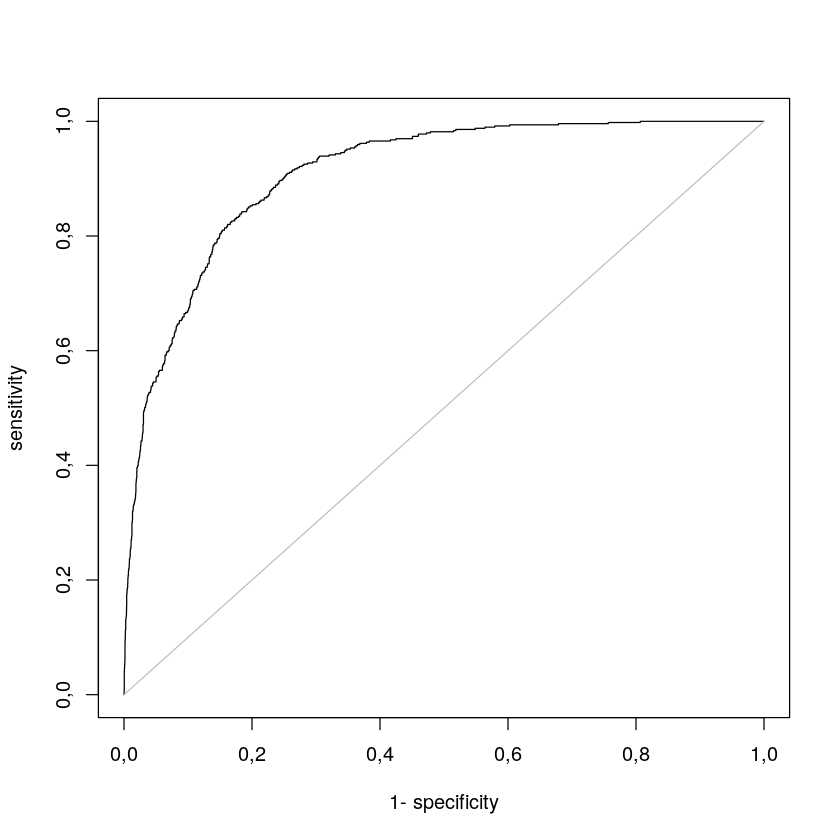

In [24]:
# Aquí solo copio las instrucciones dadas para entender con un ejemplo como funciona AUC

roc<-roc(out,as.factor(datT[,1]))
auc(roc)
plot(roc)

Por primera cosa, tenemos que entrenar el modelo, con las opciones y la muestra de entrenamiento que queramos.

Una vez que el modelo está listo, lo aplicamos a la muestra de test, con predict.

Mientras que antes se fijaba un umbral para decidir si el numero había sido identificado correctamente (out.bin.test <- as.double(out.test > 0.5)), ahora dejamos que la curva ROC nos diga cuales son la tasa de acierto (sensitivity) y la tasa de equivocación (1 - specificity) del modelo, dependiendo del umbral.

En particular, un buen modelo es capaz de proporcionar una sensitivity próxima a 1 cuando la (1 - specificity) sigue siendo pequeña. Esto quiere decir que el modelo clasifica correctamente un porcentage de los digitos que buscamos, y no obstante eso se equivoca muy poco en aceptar como correctamente clasificados digitos distinto del que queremos.

En el caso ideal entonces, la curva ROC es la recta y = 1.

Como eso en general no se puede conseguir, podemos evaluar la bondad de un modelo considerando el area debado de la curva ROC (area under curve, AUC): más grande el area, mejor el modelo.

Dicho esto, al final para poder usar un modelo para clasificar, el umbral se tiene que fijar. El valor del umbral depende de lo que queremos del modelo:
- si necesitamos, por ejemplo, que todos los numeros que buscamos se clasifiquen correctamente, y no va a ser un problema que 'se cuelen' numeros mal clasificado, fijamos el umbral a un valor bajo, para máximizar la sensitivity, dejando que (1 - specificity) crezca también;
- si necesitamos que los números que seleccionamos sean exclusivamente los que buscamos (queremos ser muy especificos), el umbral tendrá que ser muy alto, de manera que nos quedaremos con menos números (perdemos en sensitivity) pero ganando en specificity.

[1] 0


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 1


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 2


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 3


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 4


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 5


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 6


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 7


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 8


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 9


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


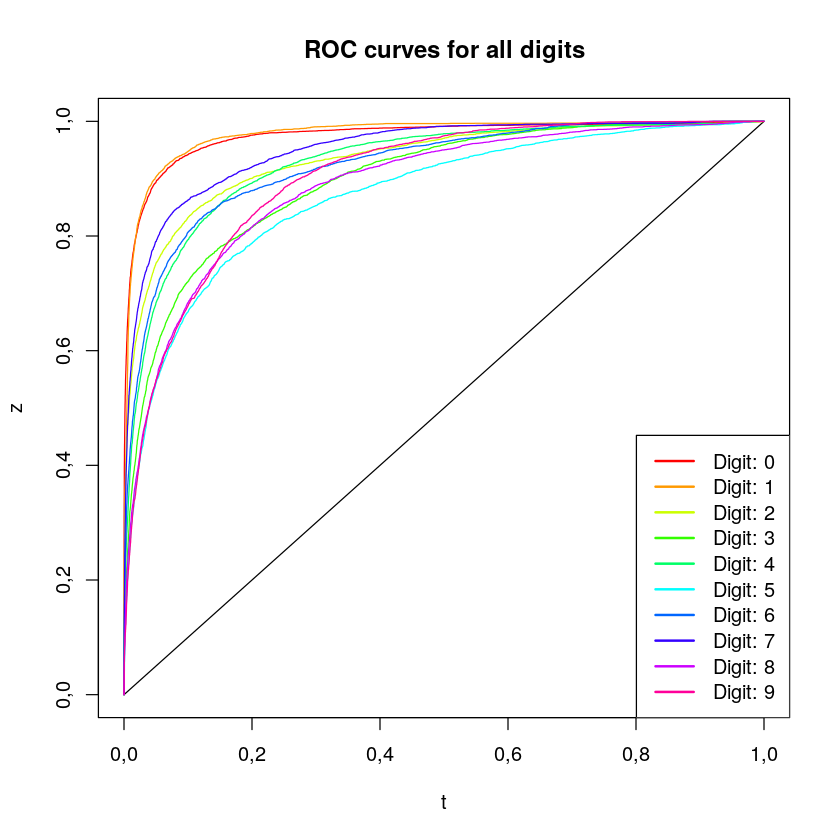

In [50]:
i <- sample(1:10000, 5000)
q <- 10001:60000

# preparo el canvas y los colores
t = 0:1
z= t

plot(t,z, type = "l",
        main = paste("ROC curves for all digits"))

cols <- rainbow(10)

for (N in numbers){
    print(N)

    # y_train: sample de train

    # añado una columna a la muestra de train, que vale:
    # 1 si es el numero que queremo
    # 0 si es otro numero

    my.y <- y_train;
    my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

    my.dat <- data.frame(my.y,x_train)

    my.dat.train <- my.dat[i,]
    my.dat.test  <- my.dat[q,]

    # Considero un pixel cada 20
    j <- seq(1,784,20)

    # Entrenamiento del modelo
    my.model <- glm(my.dat.train$my.y~., data = my.dat.train[,j], family = binomial(link = "logit"))

    # Aplico el modelo a la muestra de test
    out.test<- predict(object=my.model, newdata = my.dat.test);

    roc<-roc(out.test,as.factor(my.dat.test[,1]))
    auc(roc)
    plot(roc,
    col = cols[N+1],
    add = T)
}
legend("bottomright", legend=paste("Digit:",0:9), lwd=2, col=cols)

Mirando las curvas ROC de todos los digitos, observamos que los digitos que tenían una accuracy más alta son los que presentan una curva ROC con más area por debajo, confirmando cuanto dicho antes.